# The Fast Fourier Transform

The FFT is one of the most important algorithms in all of computing.

The (one-dimensional) discrete Fourier transform (DFT) is defined as

$X_k = \sum_{m=0}^{n-1} x_m \exp(-2 \pi i k \frac{m}{n} )$

for $n$ input data samples $x_m$, $m = 0, 1, ..., n-1$, and producing outputs $k = 0, 1, ..., n-1$.
The input data samples are assumed to be sampled on a uniform grid (eg, a sound wave sampled at
a regular grid of times).

(This form of the definition is from Wikipedia: https://en.wikipedia.org/wiki/Fast_Fourier_transform)

The data vector $x_m$ is assumed to be uniformly-spaced samples of a signal.

In this general form, the inputs $x_m$ and output $X_k$ are both complex.

We can write this as a matrix equation,
$X = F x$
where $x$ and $X$ are vectors and $F$ is the matrix of Fourier terms, $F_{k,m} = \exp( -2 \pi i k m / n)$.

In this form, row $k$ describes a sinusoid that completes $k$ cycles over the number of samples, $n$.

(The ratio $m/n$ goes from $0$ _almost_ up to $1$, so $k m / n$ goes from $0$ _almost_ up to $k$, and then scaling it by $2 \pi$ means it _almost_ goes up $k$ complete cycles.  And finally, recall that $\exp(i v) = cos(v) + i sin(v)$, so we will sometimes talk about the "cosine term" (real part) and the "sine term" (imaginary part) below.)

In [1]:
import numpy as np
import pylab as plt

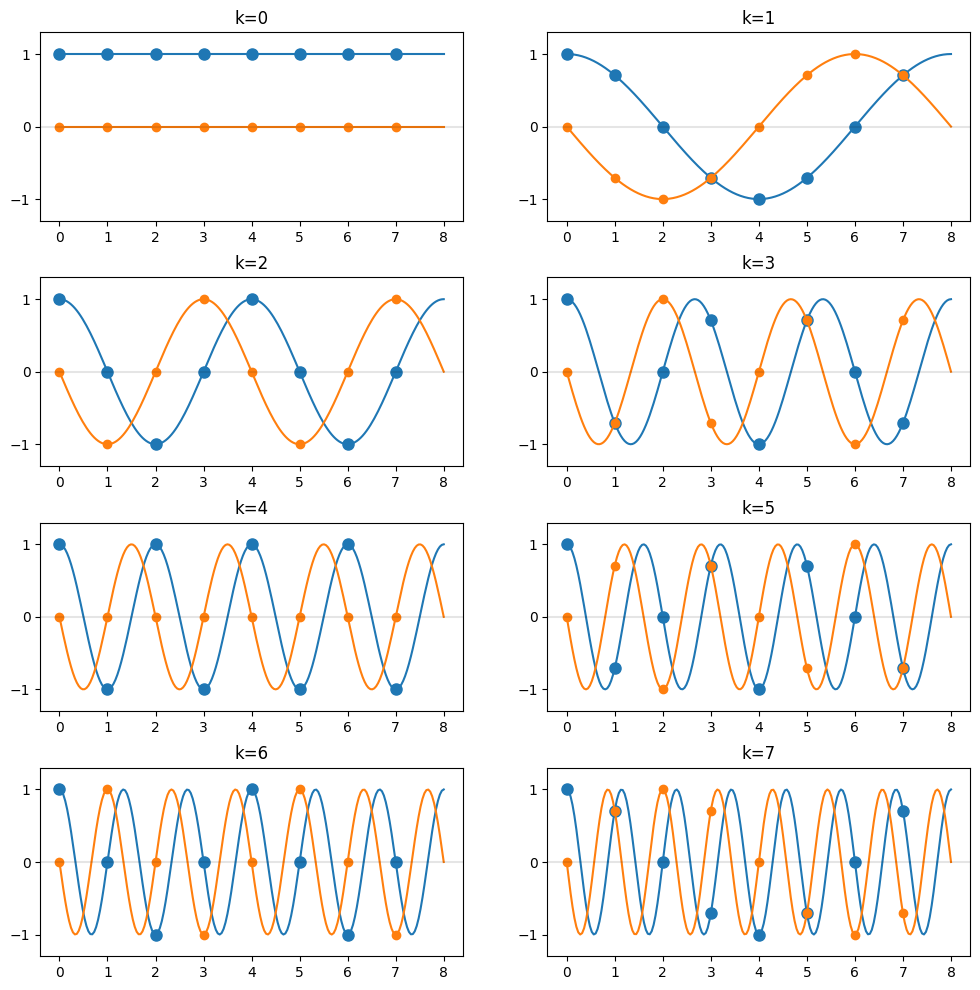

In [6]:
# Let's draw the n=8 case.
n = 8
# These are the sample points "m"
m = np.arange(n)
# I will also plot the continuous sinusoids
mm = np.linspace(0, n, 200)
plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace=0.3)
for k in range(n):
    plt.subplot(n//2, 2, k+1)
    plt.title('k=%i' % k)
    p1 = plt.plot(m, np.cos(-2. * np.pi * k * m / n), 'o', ms=8, label="Real")
    plt.plot(mm, np.cos(-2. * np.pi * k * mm / n), '-', color=p1[0].get_color())
    p2 = plt.plot(m, np.sin(-2. * np.pi * k * m / n), 'o', ms=6, label="Imaginary")
    plt.plot(mm, np.sin(-2. * np.pi * k * mm / n), '-', color=p2[0].get_color())
    plt.axhline(0, color='k', alpha=0.1)
    plt.yticks([-1,0,1])
    plt.ylim(-1.3, 1.3)

In these plots, you can see that the terms for row $k$ _almost_ complete $k$ cycles of the sinusoid in the $n=8$ data samples; if you added the $m=8$ point, they would each return to the value they started at.

## Applications

_There are so many_.  A few that come up in my own work:

  * Radio astronomy with the CHIME and CHORD telescopes.  After amplifying and sampling the signal, the first thing we do is convert to Fourier space, using FPGA hardware.  Among many other things, this allows filtering Radio Frequency Interference that would otherwise swamp the faint astrophysical signals we are looking for.

![CHORD Fengine](chord.png)
<img src="frb.png" width=800 />

  * Convolution theorem for predicting the appearance of galaxies observed by telescopes through turbulent atmosphere.

<img src="img.png" width=400 /> <img src="mod.png" width=400 />

  * DESI cosmology analyses.  It's often mathematically convenient to convert from the (real-space) _correlation function_ to the (Fourier space) _power spectrum_ of clustering (eg, of galaxies), because in linear cosmological theory, densities at different scales evolve independently, and it is easier to make power-spectrum predictions from theory.

<img src="nbody.png"> <img src="corr.png" width=600 />

### Convolution theorem

This is a super important application for FFTs, because it allows us to speed up discrete convolutions:

$y_i = \sum_{k=0}^{K-1} x_{i - k} h_k$

with a _signal_ $x_i$ of size $N$, and a _kernel_ $h_k$ of size $K$.  Computing it this way costs $NK$ operations, which gets big if $K \simeq N$.

The discrete convolution theorem says that the Fourier transform $Y$ of $\{y_i\}$ is

$Y = X \times H$

so we can compute the convolution by converting the $x$ and $h$ into Fourier space, multiplying them, and inverse-Fourier transforming to get $y$:

$y = IFFT(FFT(x) * FFT(h))$

which costs $O(N \log N)$.

## Aliasing

Let's look at the $k=6$ row, and just the real part:

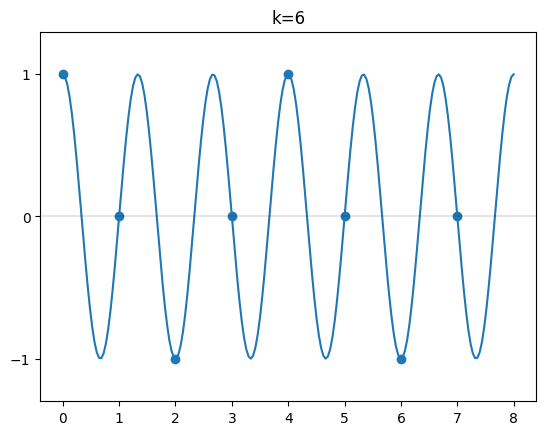

In [15]:
k = 6
plt.title('k=%i' % k)
p1 = plt.plot(m, np.cos(-2. * np.pi * k * m / n), 'o', label="Real")
plt.plot(mm, np.cos(-2. * np.pi * k * mm / n), '-', color=p1[0].get_color())
plt.axhline(0, color='k', alpha=0.1)
plt.yticks([-1,0,1])
plt.ylim(-1.3, 1.3);

Now observe that we can use a _lower-frequency_ sinusoid that also hits all those data points.

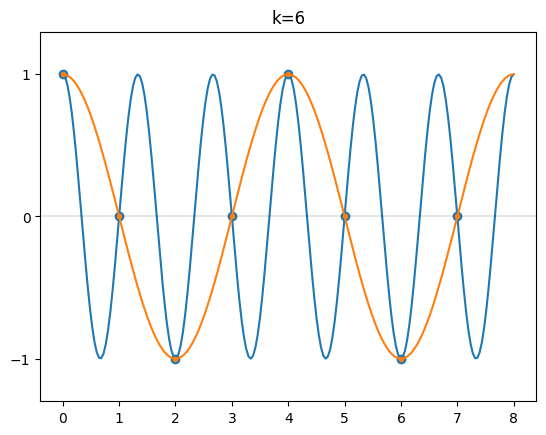

In [19]:
k = 6
plt.title('k=%i' % k)
p1 = plt.plot(m, np.cos(-2. * np.pi * k * m / n), 'o', label="Real")
plt.plot(mm, np.cos(-2. * np.pi * k * mm / n), '-', color=p1[0].get_color())
plt.axhline(0, color='k', alpha=0.1)
plt.yticks([-1,0,1])
plt.ylim(-1.3, 1.3)
k = 2
p2 = plt.plot(m, np.cos(-2. * np.pi * k * m / n), 'o', ms=3)
plt.plot(mm, np.cos(-2. * np.pi * k * mm / n), '-', color=p2[0].get_color());

It turns out that if we want to hit _both_ the real and the imaginary parts, we have to set the aliasing frequency to $-(n-k)$:

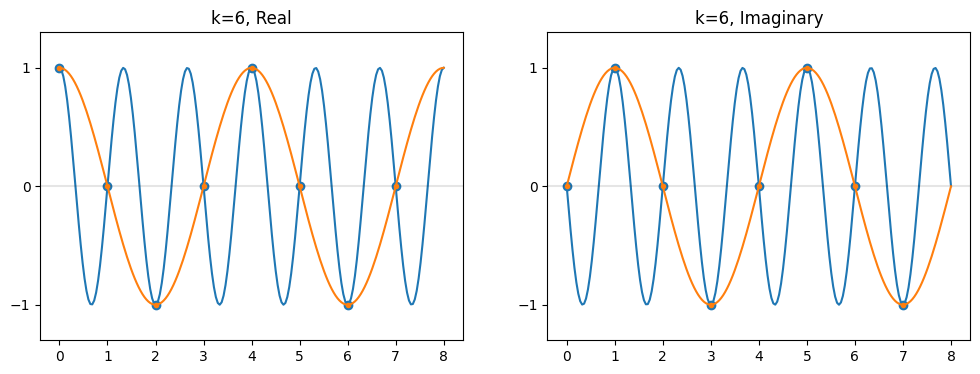

In [25]:
plt.figure(figsize=(12,4))
k = 6
plt.subplot(1,2,1)
plt.title('k=%i, Real' % k)
p1 = plt.plot(m, np.cos(-2. * np.pi * k * m / n), 'o', label="Real")
plt.plot(mm, np.cos(-2. * np.pi * k * mm / n), '-', color=p1[0].get_color())
plt.axhline(0, color='k', alpha=0.1)
plt.yticks([-1,0,1])
plt.ylim(-1.3, 1.3)
plt.subplot(1,2,2)
plt.title('k=%i, Imaginary' % k)
p2 = plt.plot(m, np.sin(-2. * np.pi * k * m / n), 'o', label="Imaginary")
plt.plot(mm, np.sin(-2. * np.pi * k * mm / n), '-', color=p2[0].get_color())
plt.axhline(0, color='k', alpha=0.1)
plt.yticks([-1,0,1])
plt.ylim(-1.3, 1.3)

k = -2
plt.subplot(1,2,1)
p2 = plt.plot(m, np.cos(-2. * np.pi * k * m / n), 'o', ms=3)
plt.plot(mm, np.cos(-2. * np.pi * k * mm / n), '-', color=p2[0].get_color());
plt.subplot(1,2,2)
p2 = plt.plot(m, np.sin(-2. * np.pi * k * m / n), 'o', ms=3)
plt.plot(mm, np.sin(-2. * np.pi * k * mm / n), '-', color=p2[0].get_color());

The point here is simply that in our definition of the Fourier transform, $k$ goes up to $n-1$, but
for $k > n/2$, the Fourier coefficients are exactly equal to the terms you would get if you plugged $-(n-k)$ into
the formula.  In documentation for the FFT, you will often hear these terms described as "negative frequencies"; that's what they're talking about.

One other important piece of terminology is the _Nyquist frequency_.  This is the $k = n/2$ term.

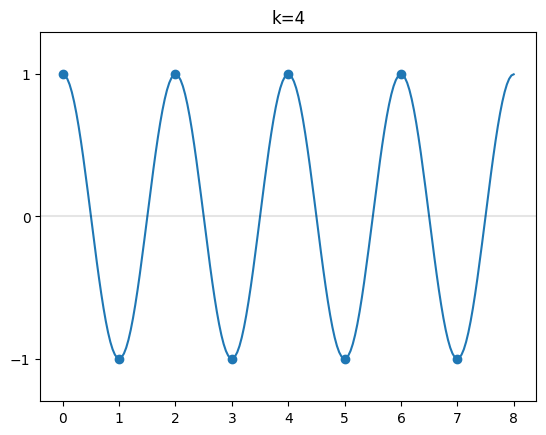

In [26]:
k = 4
plt.title('k=%i' % k)
p1 = plt.plot(m, np.cos(-2. * np.pi * k * m / n), 'o', label="Real")
plt.plot(mm, np.cos(-2. * np.pi * k * mm / n), '-', color=p1[0].get_color())
plt.axhline(0, color='k', alpha=0.1)
plt.yticks([-1,0,1])
plt.ylim(-1.3, 1.3);

Looking at the sample points, you can see that this signal is showing the maximum variation possible -- it's alternating between the maximum and the minimum possible value on alternating samples.  Intuitively, this is the fastest-varying signal that you can correctly capture by sampling this many data points.  Any sinusoid varying faster than this will have a lower-frequency alias.

## Real inputs

What we have described here accepts, in general, a complex signal $x$ and returns a complex Fourier transform $X$.

If the inputs $x$ are all _real_ numbers, then the frequencies above the Nyquist frequency just end up being the complex conjugates of the corresponding $n-k$ term.

To take advantage of this, Numpy (and other programming languages) always provide a special `rfft()` function that accepts real inputs and returns only the $k=0$ to $k=n/2$ terms.  The $k=0$ and $k=n/2$ output terms are both real, and the rest are complex.

Let's just verify some of these things for ourselves!

In [27]:
# For a data vector, let's just draw random samples
x = np.random.normal(size=n)
# Here is the "standard" FFT
X = np.fft.fft(x)
X

array([-4.89092108+0.j        ,  0.14008469-1.45977007j,
       -2.78623032+3.3270394j , -0.06872616-2.75268206j,
        0.2434365 +0.j        , -0.06872616+2.75268206j,
       -2.78623032-3.3270394j ,  0.14008469+1.45977007j])

In [34]:
# Let's just spot-check a single term: the k=3 term, X[3] above
k = 3
X_3_real = sum(np.cos(-2. * np.pi * k * m / n) * x)
X_3_imag = sum(np.sin(-2. * np.pi * k * m / n) * x)
print(complex(X_3_real, X_3_imag), 'vs', X[3])

(-0.06872616133942-2.7526820581922555j) vs (-0.06872616133942233-2.752682058192254j)


In [38]:
# To get back the original signal x, we can use the inverse Fourier transform:
print("x       = ", x)
x_again = np.fft.ifft(X)
print("x_again = ", x_again)

x       =  [-1.25965352 -0.69197829 -0.20760599  0.89771563 -1.29533279 -2.25513081
  0.43885    -0.51778532]
x_again =  [-1.25965352+0.j -0.69197829+0.j -0.20760599+0.j  0.89771563+0.j
 -1.29533279+0.j -2.25513081+0.j  0.43885   +0.j -0.51778532+0.j]


So you can see that running `ifft` gives us back our input values `x`, though as complex numbers.  We can also use the `rfft()` and `irfft()` routines to assume real-valued samples.

In [40]:
X_real = np.fft.rfft(x)
X_real

array([-4.89092108+0.j        ,  0.14008469-1.45977007j,
       -2.78623032+3.3270394j , -0.06872616-2.75268206j,
        0.2434365 +0.j        ])

You can see that the `rfft()` routine gives us just the first `n/2 + 1` elements, and the first and last ones are real.

In [43]:
print("Original x = ", x)
x_real = np.fft.irfft(X_real, n)
print("x_real     = ", x_real)

Original x =  [-1.25965352 -0.69197829 -0.20760599  0.89771563 -1.29533279 -2.25513081
  0.43885    -0.51778532]
x_real     =  [-1.25965352 -0.69197829 -0.20760599  0.89771563 -1.29533279 -2.25513081
  0.43885    -0.51778532]


And here you can see that the `x_real` we get back is _almost_ but not _exactly_ equal to the input `x` -- due to numerical errors, in the ~15th digit.

Speaking of precision... we can also use 32-bit floating-point values (the default is 64-bit floating-point), and then when we "round-trip" a random vector `x` through the FFT and inverse-FFT, we will get errors in about the 7th digit.

In [44]:
# Draw 32-bit random numbers
x32 = np.random.normal(size=n).astype(np.float32)
# Send them through the FFT and inverse-FFT
np.fft.irfft(np.fft.rfft(x32), n) - x32
# (if you run this a few times you'll get different random errors, all of order 10^{-8}.)

array([-3.7252903e-09,  0.0000000e+00,  5.9604645e-08, -5.9604645e-08,
       -2.9802322e-08,  5.9604645e-08,  0.0000000e+00,  0.0000000e+00],
      dtype=float32)

The Numpy documentation gives some good background and definitions and descriptions of the ordering of the output terms: https://numpy.org/doc/stable/reference/routines.fft.html#background-information

# Inverse Fourier transform

The inverse transform is defined (eg, on the Numpy page above) as

$x_m = \frac{1}{n} \sum_{k=0}^{n-1} X_k \exp(2 \pi i m \frac{k}{n})$

Notice that this looks pretty similar to the forward discrete Fourier transform, except for the $1/n$ normalizer, and the $+$ sign on the $\exp$.

# Basis sets

Above, we wrote the Fourier transform as a matrix equation: $X = F x$.

If you think of the data vector $x$ as a vector in an $n$-dimensional vector space (that's usually a huge-dimensional space!), then $F$ projects $x$ into
the Fourier basis; it's sort of like a rotation matrix that converts the vector $x$ into its position in the
Fourier coordinate system.  In this view, the inverse Fourier transform rotates coordinates in Fourier spae back to coordinates in the original data space.

The Fourier basis is great because it's an _orthonormal basis_: each matrix row has equal "length", and the rows are orthogonal to each other.  Among other things, this means the $F$ matrix is well conditioned and numerically very well behaved.

We have seen other basis sets in this course: when we were fitting a polynomial to a data set, we set up an $A$ matrix where the rows were powers of the $m$ values -- so we had a constant row, a linear row, a quadratic row, a cubic row, and so on.  If we had continued until $A$ was square, that would also be a basis set, but not a very good one -- the rows point in very similar directions in the vector space, which means that they are highly correlated, and the $A$ matrix is poorly conditioned.

Another basis set we have seen is the Chebyshev polynomials.  Even though they also use polynomials, the Chebyshev terms combine the different powers in a way that cancels out the correlated parts, resulting in an  orthonormal basis set.  I think about it like this: the Chebyshev cubic term, for example, describes how a cubic wiggles *differently than a quadratic wiggles*.


# Speed

The "Fast" part of the Fast Fourier Transform refers to the fact that the algorithm has _complexity_ or _scaling_ of $O(n \, log \, n)$.  The matrix version I wrote above would cost $O(n^2)$ to compute, so as $n$ grows large you
can see that $n \, log \, n$ is going to be much much better.

In practice, also, people have put a _lot_ of effort into making FFT routines very efficient and fast.

The FFT works by taking a problem of size $n$ and splitting it into $2$ (or some other number of) sub-problems, and then spending order-$n$ number of operations to turn those sub-problems back into an answer to the original problem.  If the $n$ is small enough (eg, maybe $n=8$), it can solve it directly with something like my matrix version, at order-1 cost.  For a large $n$, it has to split it in half $log_2 n$ times until the sub-problems are size $n=8$.  So it has to do $n$ work for each of $log_2(n)$ levels, resulting in the $n \, log(n)$ complexity.

One catch is that in practice, these routines work best when $n$ is a product of small primes -- ideally a power of $2$.  So in practice you will often see people set up problem sizes like $n=4096 = 2^{12}$ to take advantage of this practicality of the FFT algorithm.  Let's see for ourselves how it scales!

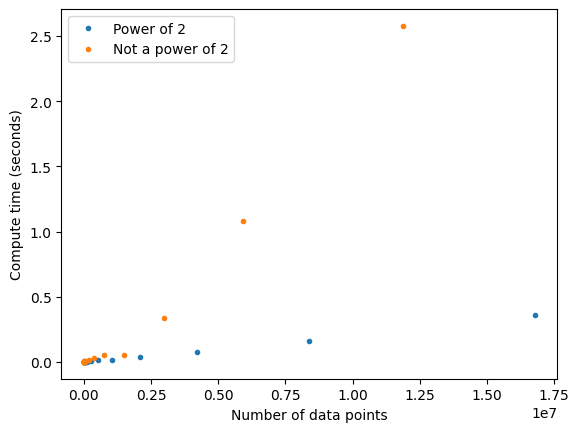

In [8]:
import time
# Time the real FFT and inverse-real-FFT, returning the compute time in seconds.
def time_fft(n):
    # draw random data
    x = np.random.rand(n)
    t0 = time.process_time()
    x_again = np.fft.irfft(np.fft.rfft(x))
    t1 = time.process_time()
    return t1-t0

# Choose problem sizes "n" that are powers of 2, and ~sqrt(2) times powers of two.
pows = np.arange(4, 24.1, 0.5)
nn = np.round(2. ** pows).astype(int)
times = []
for n in nn:
    t = time_fft(n)
    times.append(t)

plt.plot(nn[::2], times[::2], '.', label="Power of 2")
plt.plot(nn[1::2], times[1::2], '.', label="Not a power of 2")
plt.ylabel('Compute time (seconds)')
plt.xlabel('Number of data points')
plt.legend();

This should make more sense in log space, but even in the plot above we can see that the $n \, log(n)$ growth -- for powers of 2 inputs -- is really slow.

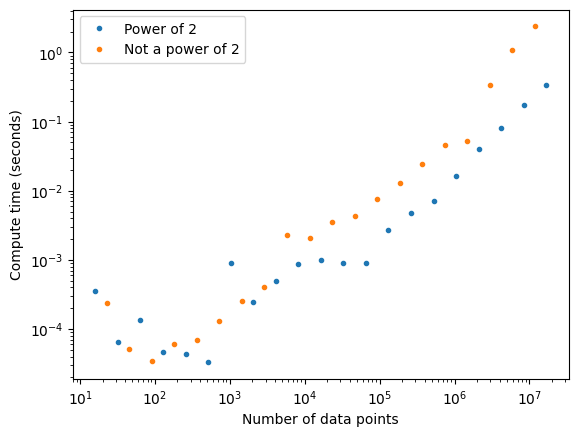

In [50]:
plt.plot(nn[::2], times[::2], '.', label="Power of 2")
plt.plot(nn[1::2], times[1::2], '.', label="Not a power of 2")
plt.ylabel('Compute time (seconds)')
plt.xlabel('Number of data points')
plt.legend()
plt.xscale('log')
plt.yscale('log')

Here, we can see that non-power-of-2 inputs can be several times slower.  Let's see how good/bad it can get!

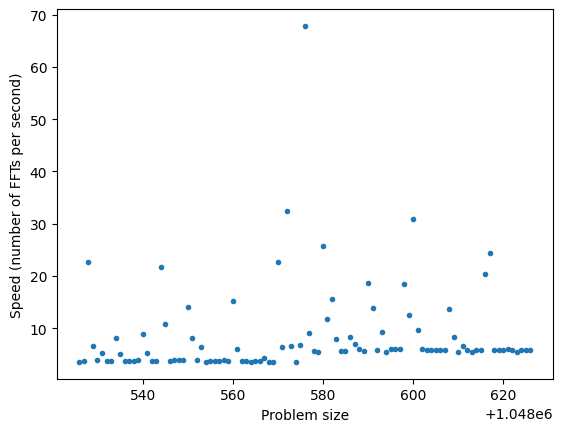

In [54]:
# Let's look at problem sizes that are close to 2^20 = about a million.
nn = np.arange((1<<20) - 50, (1<<20) + 51)
times = []
for n in nn:
    t = time_fft(n)
    times.append(t)
times = np.array(times)
# Instead of time taken, let's plot the "speed" - number of FFT we could compute per second.
plt.plot(nn, 1./times, '.')
plt.xlabel('Problem size')
plt.ylabel('Speed (number of FFTs per second)');

In [56]:
min(1 / times), max(1 / times)

(np.float64(3.5657106996280405), np.float64(67.81959986440366))

So you can see that the speed (on my computer) ranges from ~4 FFTs per second up to about 60 FFTs per second, with problems of almost identical sizes, just because of the details of how the FFT is implemented.  The fastest is of course the power-of-2 input, and this is why you will very often see people setting up power-of-2 inputs in the wild.  One very common strategy is to _pad_ the input (eg, add zeros to your data vector until its size is a power of 2), to get this speed kick.

# The algorithm

This is from https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm

The core insight is that you can split the sum into the _odd_ and _even_ elements in the array, 
run the DFT on each of those smaller problems, and then compute
_two_ terms in the DFT by combining the odd and even results.
Applied recursively, this gives us a _divide and conquer_ type algorithm.


From that wikipedia page, the following pseudocode is given:

<pre>
X0,...,N−1 ← ditfft2(x, N, s):             DFT of (x0, xs, x2s, ..., x(N-1)s):
    if N = 1 then
        X0 ← x0                                     trivial size-1 DFT base case
    else
        X0,...,N/2−1 ← ditfft2(x, N/2, 2s)             DFT of (x0, x2s, x4s, ..., x(N-2)s)
        XN/2,...,N−1 ← ditfft2(x+s, N/2, 2s)           DFT of (xs, xs+2s, xs+4s, ..., x(N-1)s)
        for k = 0 to (N/2)-1 do                      combine DFTs of two halves:
            p ← Xk
            q ← exp(−2πi/N k) Xk+N/2
            Xk ← p + q 
            Xk+N/2 ← p − q
        end for
    end if
</pre>

In [ ]:
def diy_fft

In [ ]:
def matrix_ft

In [ ]:
# Plot the timings for the different algorithms
t_matrix = []
t_diy    = []
t_numpy  = []
N_matrix = 2 ** np.arange(5, 14)
N_diy    = 2 ** np.arange(5, 14)
N_numpy  = 2 ** np.arange(5, 14)

for NN,t,func,name in [(N_matrix, t_matrix, matrix_ft,  'Matrix'),
                       (N_diy   , t_diy,    diy_fft,    'DIY'),
                       (N_numpy , t_numpy,  np.fft.fft, 'Numpy')]:
    for N in NN:
        x = np.random.rand(N)
        t0 = time.process_time()
        X1 = func(x)
        t1 = time.process_time()
        t.append(t1-t0)
    plt.plot(NN, t, '.-', label=name)
#plt.xscale('log')
#plt.yscale('log')
plt.legend();
#plt.xlim(0,2**13)

# Convolution

<img src="https://www.legacysurvey.org/viewer/cutout.jpg?ra=169.5885&dec=26.6341&layer=ls-dr9&pixscale=0.262&width=256&height256">

In [154]:
# Let's fetch some real astronomical imaging data:
url = 'https://www.legacysurvey.org/viewer/cutout.fits?ra=169.5885&dec=26.6341&layer=ls-dr9&pixscale=0.262&bands=r&width=256&height256'

In [125]:
import requests
r = requests.get(url)
# Write it out as a FITS file, read it back in using the "fitsio" package:
#import fitsio
#open('/tmp/file.fits','wb').write(r.content)
#img = fitsio.read('/tmp/file.fits')

In [145]:
# Manipulate raw byte content... it has a 2880-byte header, then 256*256 4-byte, big-endian floats.
imgdata = r.content[2880:]
imgdata = imgdata[:256*256*4]
img = np.frombuffer(imgdata, dtype='>f').reshape((256,256))

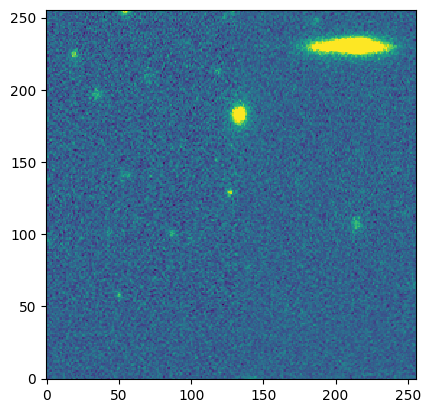

In [149]:
plt.imshow(x, interpolation='nearest', origin='lower', vmax=0.05);

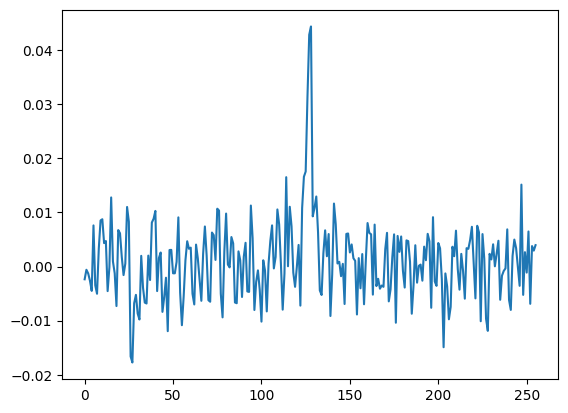

In [155]:
plt.plot(img[128,:]);

In [151]:
#kernel = 

In [152]:
# np.convolve

In [96]:
#from scipy.ndimage import convolve1d

In [153]:
# convolve1d

In [ ]:
# diy convolution with FFTs; offsets & wraps

# Pictures of cats (finally!)

In [174]:
img = plt.imread('violet.jpg')

In [175]:
img.shape, img.dtype

((2048, 2048, 3), dtype('uint8'))

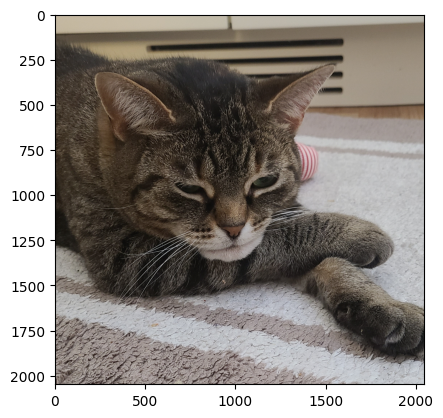

In [177]:
plt.imshow(img);

# An experiment on some real data

Below here is the notebook I showed in the lecture, with some extra annotations.

We will look at running and investigating the results of the FFT on some real data - an audio recording of an terrible guitar player (me) twanging his way up two octaves of an E-major scale.

In [91]:
import IPython
IPython.display.Audio('dstn-guitar-2.wav')

In [60]:
import soundfile as sf

In [66]:
data, samplerate = sf.read('dstn-guitar-2.wav')

In [67]:
samplerate

44100

In [68]:
data.shape, data.dtype

((616320,), dtype('float64'))

In [69]:
data.min(), data.max()

(np.float64(-0.90875244140625), np.float64(0.779876708984375))

As I described in class, a WAV file is about the simplest imaginable way of storing sound: it records the value
of the waveform, 44,100 times per second -- so that the Nyquist frequency is above the limit of human hearing.  This means that for all practical purposes, the signal can be exactly recreated by making a speaker move in proportion to the sampled data values.

This clip was recorded with 16 bits per sample, as we'll see below.

This is similar to the format used for CD audio -- 2 channels (stereo), of 16-bit samples, 44,100 samples per second.  Audio CDs typically hold around 74 minutes of audio, so 74 minutes * 2 channels * 16 bits/sample * (1 byte/8 bits) * 44100 samples/second * 60 seconds/minute = 750 MB.

In contrast, compressed formats like MP3 use about 10% as much space.

So my audio file has 616,320 samples -- about 15 seconds of audio -- and the values are floating-point between about -1 and +1.  Here's a plot of 1000 samples.  If we assume that the samples were uniformly spaced between -1 and +1 with 16 bits = 65536 different values, then we can scale by that value and see that the samples are indeed integers.

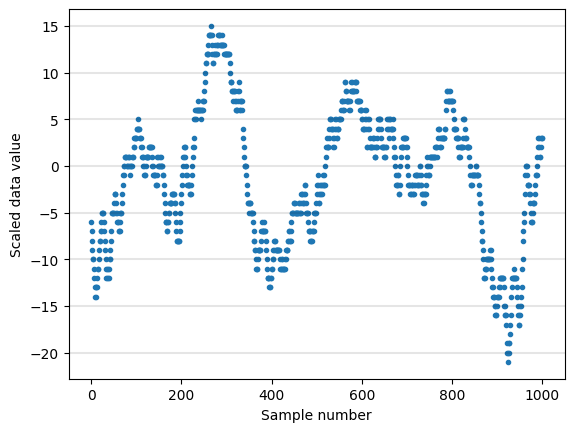

In [76]:
plt.plot(data[15000:16000] * 256 * 256 / 2, '.')
plt.xlabel('Sample number')
plt.ylabel('Scaled data value');
for y in np.arange(-20, +20, 5):
    plt.axhline(y, color='k', alpha=0.1)

This is a very quiet part of the recording.  Looking at a time when I have just plucked the first note:

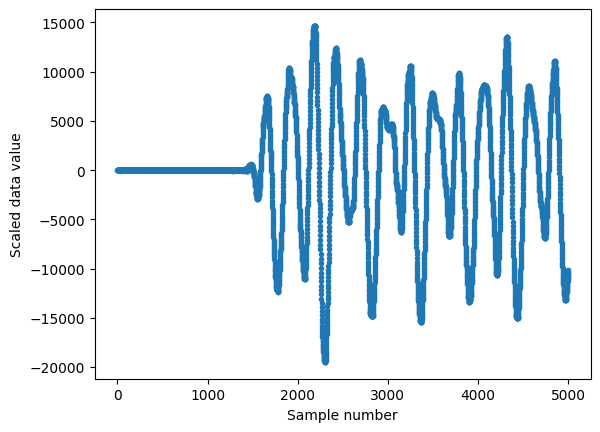

In [78]:
plt.plot(data[68000:73000] * 256 * 256 / 2, '.')
plt.xlabel('Sample number')
plt.ylabel('Scaled data value');

Let's look at a chunk of this recording - 

In [80]:
# chunk size
cs = 1024
# which chunk number to look at -- let's grab the start of the first note.
ichunk = int(np.round(73000 / cs))
# first index
i0 = (ichunk-1)*cs + 1
# a subset of data, of length 2 x chunksize
sub = data[i0:i0+cs*2-1]
# The FFT (spectrum)
spec = np.fft.rfft(sub);

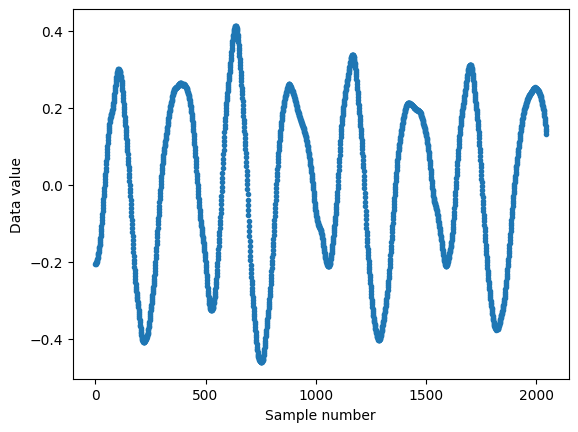

In [82]:
plt.plot(sub, '.')
plt.xlabel('Sample number')
plt.ylabel('Data value');

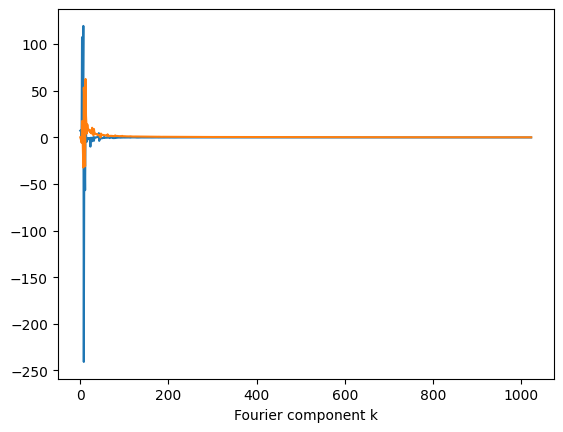

In [84]:
# Let's plot the whole FFT -- 
plt.plot(spec.real, label='Real')
plt.plot(spec.imag, label='Imaginary')
plt.xlabel('Fourier component k');

Here, we can see that there is _very_ little power in the high frequency part of the spectrum.  Let's zoom in!

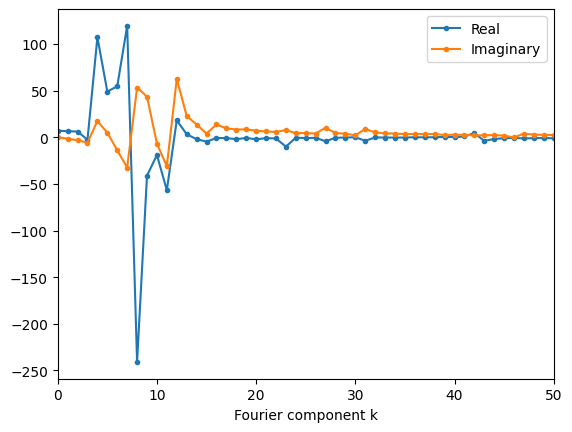

In [87]:
# Let's plot the whole FFT -- 
plt.plot(spec.real, '.-', label='Real')
plt.plot(spec.imag, '.-', label='Imaginary')
plt.xlabel('Fourier component k')
plt.legend()
plt.xlim(0, 50);

In [90]:
np.argmax(np.abs(spec))

np.int64(8)

We took 2048 samples, so this whole piece of audio is 2048 / 44100 seconds = 46 milliseconds.  So the first frequency in the FFT corresponds to a sinusoid that completes one whole cycle in 46 milliseconds, or a frequency
of about 22 Hertz.  We see the maximum amplitude in the $k=8$ FFT term, or about 172 Hz.  We also see a local peak in the $k=4$ term, or about 86 Hz.

The bottom E note on a guitar corresponds to 82 Hz, so I think we are seeing the _fundamental_ and the _first harmonic_ of this note in the Fourier transform!

Now, have a look at how well we can reconstruct the original signal from the FFT values.  In this plot, we'll plot the FFT components (individual sinusoids), and the sum of the first `N_recon` strongest components.  Play around with that number of components and see how well the reconstruction works!

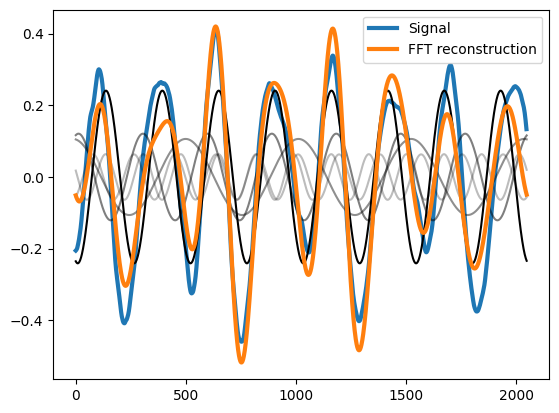

In [96]:
N_recon = 5
plt.plot(sub, label="Signal", linewidth=3)
# Find an ordering that sorts the amplitude of the FFT components, in descending order
order = np.argsort(-np.abs(spec))
# We'll scale the opacity of the Fourier components by the max amplitude
max_val = np.max(np.abs(spec))
# Let's sum up the Fourier components (our reconstruction)
outsum = 0.
for i in order[:N_recon]:
    # Fill only one term in the spectrum
    outspec = np.zeros_like(spec)
    outspec[i] = spec[i]
    # Inverse-FFT it!
    out = np.fft.irfft(outspec, 2*cs)
    # Plot that component
    plt.plot(out, '-', color='k', alpha=np.abs(spec[i])/max_val)
    # Accumulate that component into our reconstruction
    outsum = outsum + out
plt.plot(outsum, '-', linewidth=3, label="FFT reconstruction")
plt.legend();

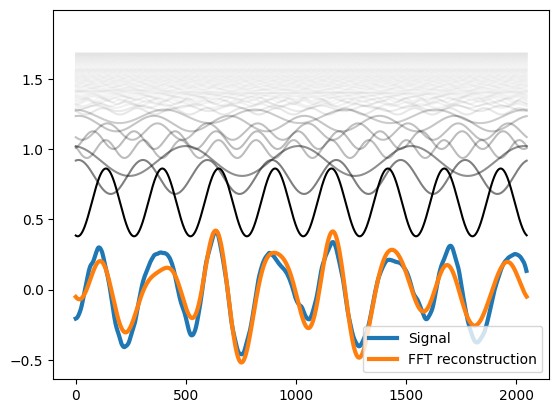

In [105]:
N_recon = 5
plt.plot(sub, label="Signal", linewidth=3)
# Find an ordering that sorts the amplitude of the FFT components, in descending order
order = np.argsort(-np.abs(spec))
# We'll scale the opacity of the Fourier components by the max amplitude
max_val = np.max(np.abs(spec))
# Let's sum up the Fourier components (our reconstruction)
outsum = 0.
offset = 0.
for j,i in enumerate(order):#[:N_recon]):
    # Fill only one term in the spectrum
    outspec = np.zeros_like(spec)
    outspec[i] = spec[i]
    # Inverse-FFT it!
    out = np.fft.irfft(outspec, 2*cs)
    # Plot that component
    a = np.max(np.abs(out))
    plt.plot(0.5+offset+a/2+out, '-', color='k', alpha=np.abs(spec[i])/max_val)
    if j < N_recon:
        # Accumulate that component into our reconstruction
        outsum = outsum + out
    offset += a
plt.plot(outsum, '-', linewidth=3, label="FFT reconstruction")
plt.legend();

Now let's look at the whole audio clip.  A very common thing to do when analyzing or processing
music or other audio data is to split it into overlapping chunks, process each chunk, and then
reassemble it.

This is called the "short-time Fourier transform" or STFT.

In [109]:
chunksize = 2048
Nchunk = np.floor(len(data)/chunksize).astype(int) - 1

In [130]:
# For each chunk we'll record the FFT (the spectrum), to make a "spectrogram"
specgram = []
# We'll try reconstructing the signal with only a few Fourier components,
# or scaling up or down some frequencies.
out_specgram = []
# We'll then reconstruct the data in this array
outdata = np.zeros((Nchunk * chunksize))
# When combining the overlapping chunks, we'll use this "apodization" vector -- which just
# goes from zero up to one and then back down to zero, linearly.
apod = np.zeros(chunksize*2)
apod[:chunksize] = (1 + np.arange(chunksize)) / chunksize
apod[-1:chunksize-1:-1] = apod[:chunksize]

# Scalings to apply to the frequencies -- eg a Gaussian band-pass filter
# These are in units of ~ 10 Hz.
pass_middle = 10
pass_width = 5
freq_scales = np.exp(-0.5 * (np.arange(chunksize+1) - pass_middle)**2 / (pass_width ** 2))

for ichunk in range(Nchunk-2):
    # Grab a chunk of data (of length "chunksize * 2") from the sound clip
    i0 = ichunk*chunksize
    sub = data[i0: i0 + chunksize*2]

    # Take the (real) FFT
    spec = np.fft.rfft(sub)
    # Record the amplitude for our spectrogram
    specgram.append(np.abs(spec))

    # Record the filtered spectrogram
    outspec = np.zeros_like(spec)

    # Option 1: take the first N Fourier components
    #I = np.argsort(-np.abs(spec))
    #Nkeep = 50
    #outspec[I[:Nkeep]] = spec[I[:Nkeep]]

    # Option 2: apply a filter to the Fourier components
    outspec[:] = spec * freq_scales
    out_specgram.append(np.abs(outspec))
    
    # Inverse-FFT the filtered spectrum back to data space
    out = np.fft.irfft(outspec, 2*chunksize)
    # Accumulate the output, using the apodizer.
    outdata[i0 : i0 + chunksize*2] += (out.real * apod)
specgram = np.vstack(specgram).T
out_specgram = np.vstack(out_specgram).T

In [124]:
# Save our filtered (reconstructed) output to "out.wav"
sf.write('out.wav', outdata, samplerate)

In [125]:
import IPython
IPython.display.Audio('out.wav')

In [ ]:
f = Figure()
ax,img = image(f[1,1][1,1], log10.(specgram[1:200,:]'), colormap=:viridis,
    colorrange=(-1,2.7), axis=(xlabel="Time chunk", ylabel="Fourier channel", title="Original spectrogram"))
Colorbar(f[1, 1][1, 2], img)
f

In [131]:
specgram.shape

(2049, 297)

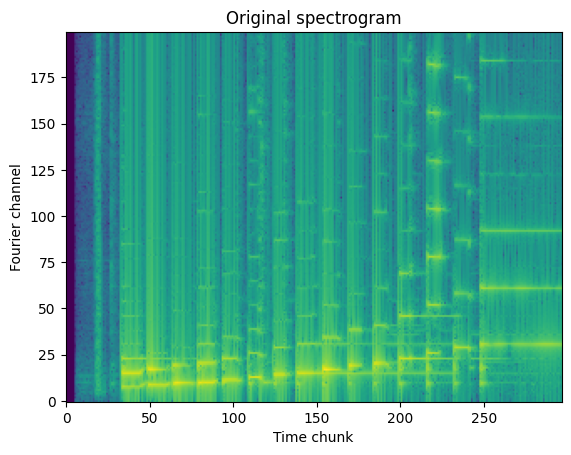

In [141]:
# Here's our input spectrogram!
plt.imshow(np.log10(np.maximum(1e-4, specgram[:200,:])), aspect='auto', origin='lower')
plt.xlabel('Time chunk')
plt.ylabel('Fourier channel')
plt.title('Original spectrogram');

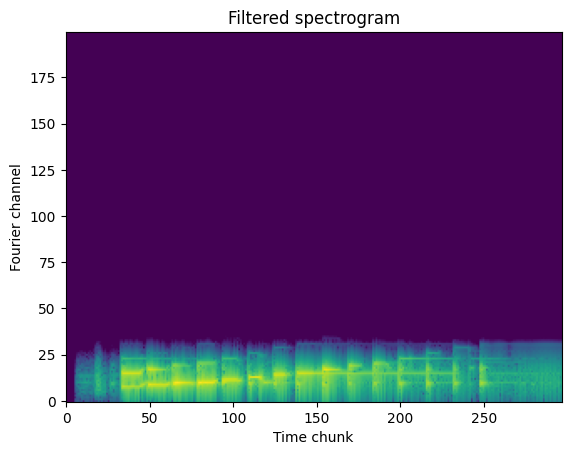

In [142]:
# Here's our input spectrogram!
plt.imshow(np.log10(np.maximum(1e-4, out_specgram[:200,:])), aspect='auto', origin='lower')
plt.xlabel('Time chunk')
plt.ylabel('Fourier channel')
plt.title('Filtered spectrogram');

Now listen to that audio file (eg, by finding the "out.wave" output file on your computer and opening it in your favorite sound-playing app.  Play around with the band-pass arguments (try setting it to catch only the lower half or upper half of the spectrogram), or try reconstructing the signal with a limited number of Fourier components.  How many do you need to get a reasonable reconstruction?  How much could that compress the representation of the sound?

That's all, folks!